In [9]:
!pip install ultralytics
!pip install roboflow
!pip install supervision

  Using cached supervision-0.21.0-py3-none-any.whl (123 kB)


In [2]:
pwd

'/content'

In [4]:
from google.colab import drive
from pathlib import Path
import os
import json
drive.mount('/content/drive')
x = '/content/drive/MyDrive/Football-Analysis-System/'
path = Path(x)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['clips',
 'yolov8x.pt',
 'runs',
 'training',
 'config.json',
 '.ipynb_checkpoints',
 'yolov8n.pt',
 'yolov5lu.pt',
 'yolo_inference.ipynb',
 'video_utils_trials.ipynb',
 'trackers',
 'stubs',
 'development_and_analysis',
 'team_assigner']

In [5]:
cd  /content/drive/MyDrive/Football-Analysis-System

/content/drive/MyDrive/Football-Analysis-System


In [10]:
from ultralytics import YOLO
import supervision as sv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.cluster import KMeans

In [11]:
def read_video(video_path):
    """read_video : reads a video file and returns the frames

    Args:
        video_path : frames of the video
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    return frames


def save_video(output_video_frames, output_video_path):
    # XVID is the output format
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    # generate a video at the path, of type fourcc @ 24 frames/second and framesize as
    # the last parameter (width, height)
    out = cv2.VideoWriter(output_video_path, fourcc, 24,
                          (output_video_frames[0].shape[1], output_video_frames[0].shape[0]))
    for frame in output_video_frames:
        out.write(frame)
    out.release

def get_center(bbox):
    x1,y1,x2,y2 = bbox
    return int((x1+x2)/2), int((y1+y2)/2)

def get_width(bbox):
    x1,y1,x2,y2 = bbox
    return int(x2-x1)

def get_height(bbox):
    x1,y1,x2,y2 = bbox
    return int(y2-y1)

In [12]:
class Tracker:
    def __init__(self, model_path):
        self.model = YOLO(model_path)
        self.tracker = sv.ByteTrack()

    def detect_frames(self, frames):
        batch_size =20
        detections = []

        # Split frames into batches of size batch_size
        # and detect each batch separately
        # for faster processing and avoid memory issues

        for i in range(0, len(frames), batch_size):
            batch = frames[i:i+batch_size]
            detections_batch = self.model.predict(batch, conf=0.1)
            detections += detections_batch

        return detections

    def get_object_tracks(self, frames, read_from_stub = False, stub_path = None):

        if read_from_stub and stub_path is not None and os.path.exists(stub_path):
            with open(stub_path, 'rb') as f:
                tracks = pickle.load(f)
            return tracks

        detections = self.detect_frames(frames)
        tracks = {
            'players':[],
            'referees':[],
            'ball':[]
        }

        for frame_num, detection in enumerate(detections):
            class_names = detection.names
            class_names_inv = {i:j for j, i in class_names.items()}

            #convert the detection to supervison format
            detection_sv = sv.Detections.from_ultralytics(detection)

            #convert goalkeeper to player object
            for index, class_id in enumerate(detection_sv.class_id):
                if class_names[class_id] == 'goalkeeper':
                    detection_sv.class_id[index] = class_names_inv['player']

            # Track objects
            detections_with_tracks = self.tracker.update_with_detections(detection_sv)

            tracks['players'].append({})
            tracks['referees'].append({})
            tracks['ball'].append({})

            # Tracking the players and the referee since they are more than one.
            # No need to track the ball using the detection with tracks since there is
            # only one ball in the video hence only one bounding ball
            for frame_detection in detections_with_tracks:
                bbox = frame_detection[0].tolist()
                class_id = frame_detection[3]
                track_id = frame_detection[4]

                if class_id == class_names_inv['player']:
                    tracks['players'][frame_num][track_id] = {"bbox":bbox}
                elif class_id == class_names_inv['referee']:
                    tracks['referees'][frame_num][track_id] = {"bbox":bbox}

            # Tracking the ball...
            for frame_detection in detection_sv:
                bbox = frame_detection[0].tolist()
                class_id = frame_detection[3]

                if class_id == class_names_inv['ball']:
                    # We're using a constant one since there's only one ball
                    tracks['ball'][frame_num][1] = {"bbox":bbox}

            if stub_path is not None:
                with open(stub_path, 'wb') as f:
                    pickle.dump(tracks, f)

            return tracks

    def draw_ellipse(self, frame, bbox, color, track_id=None):
        # Ellipse to be postioned at the bottom of the bounding box
        y2 = int(bbox[3])

        x_center, y_center = get_center(bbox)
        width = get_width(bbox)

        cv2.ellipse(frame,
                    center = (x_center, y2),
                    axes = (int(width), int(0.35*width)),
                    angle = 0.0,
                    startAngle=-45,
                    endAngle=235,
                    color = color,
                    thickness=2,
                    lineType=cv2.LINE_4)

        rectangle_width = 40
        rectangle_height = 20
        x1_rect = x_center - rectangle_width//2
        x2_rect = x_center + rectangle_width//2
        y1_rect = y2 - rectangle_height//2 + 15
        y2_rect = y2 + rectangle_height//2 + 15

        if track_id is not None:
            cv2.rectangle(frame,
                        pt1 = (int(x1_rect), int(y1_rect)),
                        pt2 = (int(x2_rect), int(y2_rect)),
                        color = color,
                        thickness = cv2.FILLED)

            x1_text = int(x1_rect) + 12
            if track_id > 99:
                x1_text -= 10
            y1_text = int(y1_rect) + 15
            cv2.putText(frame,
                        text = f'{track_id}',
                        org = (x1_text, y1_text),
                        fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale = 0.6,
                        color = (0,0,0),
                        thickness = 2
                        )

        return frame

    def draw_triangle(self, frame, bbox, color):
        y = bbox[1]
        x,_ = get_center(bbox)

        triangle_points = np.array([
            [x,y],
            [x-10,y-20],
            [x+10,y-20]
        ], dtype=np.int32)

        # Ensure the triangle_points array is not empty and is a numpy array
        if triangle_points is not None and len(triangle_points) > 0:
            # Reshape the array to the expected structure for drawContours
            triangle_points = triangle_points.reshape((-1, 1, 2))

            # Draw the filled inverted triangle
            cv2.drawContours(frame, [triangle_points], 0, color, cv2.FILLED)
            # Draw the inverted triangle border
            cv2.drawContours(frame, [triangle_points], 0, (0, 0, 0), 2)

        return frame

    def draw_annotations(self, video_frames, tracks):
        output_video_frames = []
        for frame_num, frame in enumerate(video_frames):
            frame = frame.copy()
            players_dict = tracks['players'][frame_num]
            referees_dict = tracks['referees'][frame_num]
            ball_dict = tracks['ball'][frame_num]

            # Draw Players
            for track_id, player in players_dict.items():
                color = player.get('team_color', (0, 0, 255))
                frame = self.draw_ellipse(frame, player['bbox'], color, track_id)

            # Draw Referee
            for _, referee in referees_dict.items():
                frame = self.draw_ellipse(frame, referee['bbox'], (0, 255, 255))

            # Draw Ball
            for _, ball in ball_dict.items():
                frame = self.draw_triangle(frame, ball['bbox'], (0, 255, 0))

            output_video_frames.append(frame)

        return output_video_frames


using code at main.py to get a single player

In [ ]:
# Read video
video_frames = read_video('clips/input/08fd33_4.mp4')
# Initilize Tracker
tracker = Tracker('runs/models/best.pt')
# get object tracks
tracks = tracker.get_object_tracks(video_frames, read_from_stub=True, stub_path='./stubs/track_stubs_final.pkl')

# Save cropped image of a player
for track_id, player in tracks['players'][0].items():
    if track_id != 14:
        continue
    bbox = player['bbox']
    frame = video_frames[0]

    # crop bounding box from frame
    cropped_image = frame[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2])]

    # save cropped image
    cv2.imwrite(f'./clips/output/cropped_player_{track_id}.jpg', cropped_image)
    break


# Draw output
# Draw object tracks
# output_video_frames = tracker.draw_annotations(video_frames, tracks)

# save video
# save_video(output_video_frames, 'clips/output/output_video.avi')

# save video_frame
# Already saved, that's why it's commented out
# save_video(video_frames, 'clips/output/08fd33_4.avi')

Now moving on to colour assignment

In [7]:
image_path = './clips/output/cropped_player_1.jpg'

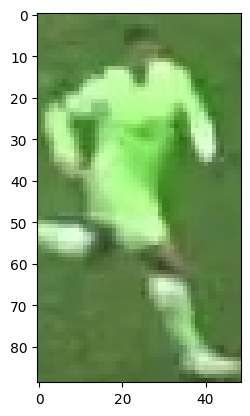

In [13]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

Taking top half of the image

In [14]:
image.shape

(89, 49, 3)

(44, 49, 3)


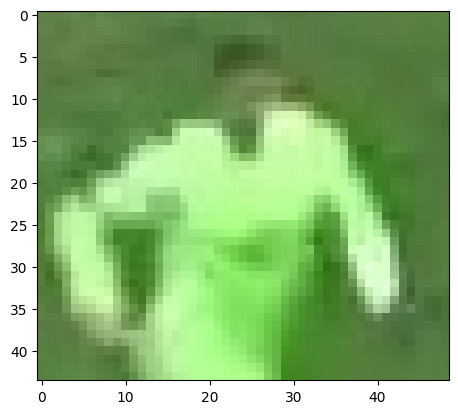

In [15]:
top_half_image = image[0:image.shape[0]//2,:]
print(top_half_image.shape)
plt.imshow(top_half_image)

Cluster image into 2 clusters


In the context of NumPy's reshape method, the -1 value is a special placeholder that tells NumPy to\
automatically calculate the size of that dimension based on the remaining dimensions and the total number of elements in the array.\
This is useful when you want to reshape an array but don't want to manually compute the new dimension sizes.

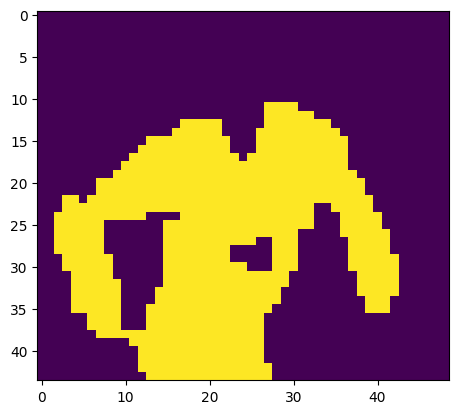

In [16]:
# reshape image into 2D array
top_half_image_2d = top_half_image.reshape(-1,3)

# Perform k-means clustering with 2 clusters using sklearn
kmeans = KMeans(n_clusters=2, n_init = 'auto',random_state=0).fit(top_half_image_2d)

# get the cluster labels
labels = kmeans.labels_
# reshape the labels into the original image shape
top_half_clustered_image = labels.reshape(top_half_image.shape[0], top_half_image.shape[1])

plt.imshow(top_half_clustered_image)

In [17]:
corner_clusters = [top_half_clustered_image[0,0],top_half_clustered_image[0, -1],top_half_clustered_image[-1, 0],top_half_clustered_image[1, -1]]
non_player_cluster = max(set(corner_clusters), key = corner_clusters.count)
print(non_player_cluster)

0


In [18]:
player_cluster = 1 - non_player_cluster
print(player_cluster)

1


In [19]:
kmeans.cluster_centers_[player_cluster]

array([     171.38,      235.65,      142.85])

code for team_assigner.py under team_assigner folder

In [20]:
class TeamAssigner:
    def __init__(self):
        self.team_colors = {}
        self.kmeans = None
        self.player_team_dict = {}

    def get_clustering_model(self, image):
        # Reshape the model
        top_half_image_2d = image.reshape(-1,3)
        # Perform k-means clustering with 2 clusters using sklearn
        kmeans = KMeans(n_clusters=2, init = "k-means++",n_init = 10,random_state=0).fit(top_half_image_2d)

        return kmeans

    def get_player_color(self, frame, bbox):
        cropped_image = frame[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2])]
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
        top_half_image = cropped_image[0:cropped_image.shape[0]//2,:]

        # clustering and get labels for each pixel
        kmeans = self.get_clustering_model(top_half_image)
        labels = kmeans.labels_

        # Reshape the labels array to match the top half image dimensions (excluding the color channels)
        top_half_clustered_image = labels.reshape(top_half_image.shape[0], top_half_image.shape[1])

        # Get the player cluster
        corner_clusters = [top_half_clustered_image[0,0],top_half_clustered_image[0, -1],top_half_clustered_image[-1, 0],top_half_clustered_image[1, -1]]
        non_player_cluster = max(set(corner_clusters), key = corner_clusters.count)
        player_cluster = 1 - non_player_cluster

        # Get the player color
        player_color = kmeans.cluster_centers_[player_cluster]

        return player_color

    def assign_team_color(self, frame, player_detections):
        player_colors = []

        for _, player_detection in player_detections.items():
            bbox = player_detection['bbox']
            player_color = self.get_player_color(frame, bbox)

            player_colors.append(player_color)

        kmeans = KMeans(n_clusters=2, init = "k-means++",n_init = 10,random_state=0).fit(player_colors)

        self.kmeans = kmeans
        self.team_colors[1] = kmeans.cluster_centers_[0]
        self.team_colors[2] = kmeans.cluster_centers_[1]

        return self.team_colors

    def get_player_team(self, frame, player_bbox, player_id):
        # if player_id alredy in team just skip it
        if player_id in self.player_team_dict:
            return self.player_team_dict[player_id]

        # get player color
        player_color = self.get_player_color(frame, player_bbox)

        team_id = self.kmeans.predict(player_color.reshape(1,-1))[0]
        team_id += 1

        # save the player_color in its team dict
        self.player_team_dict[player_id] = team_id

        return team_id

code for main.py

In [21]:
# Read video
video_frames = read_video('clips/input/08fd33_4.mp4')

In [22]:
# Initilize Tracker
tracker = Tracker('runs/models/best.pt')
# get object tracks
tracks = tracker.get_object_tracks(video_frames, read_from_stub=True, stub_path='./stubs/track_stubs_final.pkl')

# Save cropped image of a player
# Already saved hence the commenting out
# for track_id, player in tracks['players'][0].items():
#     if track_id != 14:
#         continue
#     bbox = player['bbox']
#     frame = video_frames[0]

team_assigner = TeamAssigner()
team_colors = team_assigner.assign_team_color(video_frames[0], tracks['players'][0])
print(team_colors)

for frame_num, player_track in enumerate(tracks['players']):
    # Loop over each tracked object in frame
    for player_id, track in player_track.items():
        # Get the player's team
        team = team_assigner.get_player_team(video_frames[frame_num], track['bbox'], player_id)
        # save the players team
        tracks['players'][frame_num][player_id]['team'] = team
        # save the players team color
        tracks['players'][frame_num][player_id]['team_color'] = team_assigner.team_colors[team]

# # crop bounding box from frame
# cropped_image = frame[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2])]

# # save cropped image
# cv2.imwrite(f'./clips/output/cropped_player_{track_id}.jpg', cropped_image)
# break

# Draw output
# Draw object tracks
output_video_frames = tracker.draw_annotations(video_frames, tracks)

# save video
save_video(output_video_frames, 'clips/output/output_video.avi')

# save video_frame
# Already saved, that's why it's commented out
# save_video(video_frames, 'clips/output/08fd33_4.avi')

{1: array([     181.48,      228.12,      141.15]), 2: array([      215.5,       228.4,      224.59])}
